In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch

import string
import random
import pandas as pd
import numpy as np
import os

import contextlib

import deepmatcher as dm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

from mojito import Mojito, chart

## deepmatcher wrapper 

# New Section

In [4]:
def wrap_dm(model, ignore_columns = ['label', 'id']):
  
  def wrapper(dataframe):
    data = dataframe.copy().drop([c for c in ignore_columns if c in dataframe.columns], axis = 1)
    
    data['id'] = np.arange(len(dataframe))
    
    tmp_name = "./{}.csv".format("".join([random.choice(string.ascii_lowercase) for _ in range(10)]))
    data.to_csv(tmp_name, index = False)
    
    with open(os.devnull, 'w') as devnull:
      with contextlib.redirect_stdout(devnull):
        data_processed = dm.data.process_unlabeled(tmp_name, trained_model = model)
        out_proba = model.run_prediction(data_processed, output_attributes = True)
        out_proba = out_proba['match_score'].values.reshape(-1)
    
    multi_proba = np.dstack((1-out_proba, out_proba)).squeeze()
    
    os.remove(tmp_name)
    return multi_proba
  return wrapper

In [5]:
def merge_sources(table, left_prefix, right_prefix, left_source, right_source, copy_from_table, ignore_from_table):

  dataset = pd.DataFrame(columns = {col:table[col].dtype for col in copy_from_table})
  ignore_column = copy_from_table + ignore_from_table

  for _, row in table.iterrows():
    leftid  = row[left_prefix  + 'id']
    rightid = row[left_prefix + 'id']

    new_row = {column: row[column] for column in copy_from_table}

    for id, source, prefix in [(leftid,  left_source,  left_prefix),
                               (rightid, right_source, right_prefix)]:

      for column in source.keys():
        if column not in ignore_column:
          new_row[prefix + column] = source.loc[id][column]

    dataset = dataset.append(new_row, ignore_index = True)
  return dataset

In [6]:
def build_dm_dataset(type, dataset):
  left  = pd.read_csv(os.sep.join([type, dataset, "tableA.csv"]))
  right = pd.read_csv(os.sep.join([type, dataset, "tableB.csv"]))
  train = pd.read_csv(os.sep.join([type, dataset, "train.csv"]))
  valid = pd.read_csv(os.sep.join([type, dataset, "valid.csv"]))
  test  = pd.read_csv(os.sep.join([type, dataset, "test.csv"]))
  
  train_name = "merged-{}-train.csv".format(dataset)
  valid_name = "merged-{}-valid.csv".format(dataset)
  test_name  = "merged-{}-test.csv".format(dataset)
  
  train_path = os.sep.join([type, dataset, train_name])
  valid_path = os.sep.join([type, dataset, valid_name])
  test_path  = os.sep.join([type, dataset,  test_name])
                           
  merge_sources(train, 'ltable_', 'rtable_', left, right, ['label'], ['id']).to_csv(os.sep.join([type,dataset,train_name]), index = False)
  merge_sources(valid, 'ltable_', 'rtable_', left, right, ['label'], ['id']).to_csv(os.sep.join([type,dataset,valid_name]), index = False)
  merge_sources(test,  'ltable_', 'rtable_', left, right, ['label'], ['id']).to_csv(os.sep.join([type,dataset,test_name]), index = False)
  
  train_d, validation_d, test_d = dm.data.process(
    path = os.sep.join([type, dataset]),
    train = train_name,
    validation = valid_name,
    test = test_name,
    left_prefix = 'ltable_',
    right_prefix = 'rtable_',
   )
  
  return (train_path, train_d), (test_path, test_d), (valid_path, validation_d)

## Mojito on iTunes-Amazon

Upload a pretrained model

In [14]:
dataset_type = "Structured"
dataset_name = 'iTunes-Amazon'
model_name = 'models/hybrid_natencoding.pth'
model_type='hybrid'

model = dm.MatchingModel(attr_summarizer=model_type)
model.load_state(model_name)

train_d, validation_d, test_d = dm.data.process(
    path = 'sample_data/itunes-amazon/exp5',
    train = 'train_naturalencoding.csv',
    validation = 'validation_naturalencoding.csv',
    test = 'test_naturalencoding.csv',
    left_prefix = 'ltable_',
    right_prefix = 'rtable_',
   )

In [15]:
model.run_eval(test_d)

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.5 | Load Time:    0.4 || F1:  84.37 | Prec:  81.82 | Rec:  87.10 || Ex/s: 119.40



84.37499999999999

In [16]:
data_path = 'sample_data/itunes-amazon/exp5'
test_path = data_path+'/test_naturalencoding.csv'

In [17]:
## Sample to study
data = pd.read_csv(test_path, dtype = str)

proba = wrap_dm(model)(data)
tp_group = data[(proba[:, 1] >= 0.5) & (data['label'] == '1')]
tn_group = data[(proba[:, 0] >= 0.5) & (data['label'] == '0')]

len(tp_group), len(tn_group)


Reading and processing data from "./vvvrzuvlyh.csv"
0% [############################# ] 100% | ETA: 00:00:00

(27, 71)

In [18]:
mojito = Mojito(data.columns,
                attr_to_copy = 'left',
                split_expression = " ",
                class_names = ['no_match', 'match'], 
                feature_selection = "lasso_path")

In [19]:
tp_result = mojito.drop(wrap_dm(model),
                        tp_group,
                        num_features = 15,
                        num_perturbation = 500)

Explaining 0/27



Reading and processing data from "./uitrbenjmn.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 1/27



Reading and processing data from "./jdbgmcdjtr.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 2/27



Reading and processing data from "./xrkrvpeznd.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 3/27



Reading and processing data from "./wrfwiavbmy.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 4/27



Reading and processing data from "./tjyegdviat.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 5/27



Reading and processing data from "./gzjkdypkbh.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Explaining 6/27



Reading and processing data from "./czmjpzifra.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 7/27



Reading and processing data from "./hihhunopjb.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 8/27



Reading and processing data from "./mpevhgsxtq.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 9/27



Reading and processing data from "./arrkelnnuu.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Explaining 10/27



Reading and processing data from "./bsscadnvmx.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Explaining 11/27



Reading and processing data from "./xmqtfiuqdu.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 12/27



Reading and processing data from "./ivvwufibtv.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 13/27



Reading and processing data from "./hfxzbmhswy.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 14/27



Reading and processing data from "./yjtrkkvzsu.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 15/27



Reading and processing data from "./takrwllxof.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 16/27



Reading and processing data from "./ndasseyapd.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 17/27



Reading and processing data from "./zmjuoywcze.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Explaining 18/27



Reading and processing data from "./lplybcxyvr.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Explaining 19/27



Reading and processing data from "./iiwqyqomog.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 20/27



Reading and processing data from "./srbikoylqn.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 21/27



Reading and processing data from "./wctvarxppm.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 22/27



Reading and processing data from "./sqclmxxcbp.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 23/27



Reading and processing data from "./pmxrxaqpzj.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 24/27



Reading and processing data from "./leuydtidey.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 25/27



Reading and processing data from "./ikaobuqzpr.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Explaining 26/27



Reading and processing data from "./scvwuuovci.csv"
0% [███] 100% | ETA: 00:00:00#### ] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [21]:
tn_result = mojito.copy(wrap_dm(model),
                        tn_group,
                        num_features = 15,
                        num_perturbation = 100)

Explaining 0/71



Reading and processing data from "./mdbzouitve.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.831e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.416e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 1/71



Reading and processing data from "./qbfqfzihml.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.850e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.850e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 2/71



Reading and processing data from "./rtxzgzgban.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.019e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.095e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 3/71



Reading and processing data from "./tomshazksv.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.618e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.618e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 4/71



Reading and processing data from "./pswpurzglp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.433e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.638e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 5/71



Reading and processing data from "./sbwvylhzlb.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.017e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.017e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 6/71



Reading and processing data from "./orvkhmdbck.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=8.425e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.213e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 7/71



Reading and processing data from "./naebvgthqf.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.243e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.880e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 8/71



Reading and processing data from "./kdznloyfwc.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.138e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=7.676e-03, previous alpha=6.138e-03, with an active set of 7 regressors.
  ConvergenceWarning)


Explaining 9/71



Reading and processing data from "./kdkhhdjsnx.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.907e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.055e-03, previous alpha=1.034e-03, with an active set of 7 regressors.
  ConvergenceWarning)


Explaining 10/71



Reading and processing data from "./dcuucsqhcy.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=9.229e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.614e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 11/71



Reading and processing data from "./spcacqotua.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.975e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.488e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 12/71



Reading and processing data from "./hxwnxbitot.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.331e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.331e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 13/71



Reading and processing data from "./ralsuangou.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=2.763e-03, previous alpha=2.745e-03, with an active set of 8 regressors.
  ConvergenceWarning)


Explaining 14/71



Reading and processing data from "./jevnbbsqdd.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.906e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.712e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 15/71



Reading and processing data from "./oggsoyhmvq.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.134e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 6 iterations, alpha=1.067e-03, previous alpha=1.067e-03, with an active set of 7 regressors.
  ConvergenceWarning)


Explaining 16/71



Reading and processing data from "./qiaviyuxxd.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.182e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.591e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 17/71



Reading and processing data from "./dpgfmerdqi.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.678e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.339e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 18/71



Reading and processing data from "./yskicgwjqu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.881e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.941e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 19/71



Reading and processing data from "./quwgephfom.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.184e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.919e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 20/71



Reading and processing data from "./tnmjkcfvvj.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=4.116e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.058e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 21/71



Reading and processing data from "./izcjuxvzld.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.420e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.101e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 22/71



Reading and processing data from "./qfmvvvyucu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.503e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.252e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 23/71



Reading and processing data from "./vzzeeghrys.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.601e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.300e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 24/71



Reading and processing data from "./gnjvadcccc.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.246e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.246e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 25/71



Reading and processing data from "./qszdngndhm.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 4 iterations, alpha=3.067e-02, previous alpha=1.655e-02, with an active set of 5 regressors.
  ConvergenceWarning)


Explaining 26/71



Reading and processing data from "./rmwlrxuzcu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.520e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=9.926e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 27/71



Reading and processing data from "./pgzpcooisn.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.348e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 7 iterations, alpha=4.665e-04, previous alpha=4.628e-04, with an active set of 8 regressors.
  ConvergenceWarning)


Explaining 28/71



Reading and processing data from "./qvohfsrigu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.456e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.228e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 29/71



Reading and processing data from "./qsosucvqdx.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.190e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.209e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 30/71



Reading and processing data from "./mnynenktjg.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.079e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.794e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 31/71



Reading and processing data from "./yxvcyyznhc.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.894e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.447e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 32/71



Reading and processing data from "./huhfohqqov.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.527e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.527e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 33/71



Reading and processing data from "./xyqaxmnmzu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=5.082e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.541e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 34/71



Reading and processing data from "./oyokfxpcog.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=5.966e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.983e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 35/71



Reading and processing data from "./ttsnvodvkf.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.910e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.435e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 36/71



Reading and processing data from "./jpzfvevzqm.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.991e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 8 iterations, alpha=1.459e-03, previous alpha=1.227e-03, with an active set of 9 regressors.
  ConvergenceWarning)


Explaining 37/71



Reading and processing data from "./oagbgxjeam.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.161e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.081e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 38/71



Reading and processing data from "./dsmpuvjxdj.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.490e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=6.995e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 39/71



Reading and processing data from "./vscweslkxp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.227e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=4.840e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 40/71



Reading and processing data from "./jrndafvhdy.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=5.151e-03, previous alpha=4.385e-03, with an active set of 6 regressors.
  ConvergenceWarning)


Explaining 41/71



Reading and processing data from "./yhswlqbhbw.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.545e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.724e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 42/71



Reading and processing data from "./vvfrnaliky.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.289e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.144e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 43/71



Reading and processing data from "./vazspophny.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.549e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.275e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 44/71



Reading and processing data from "./ydmighejkh.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.016e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.437e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 45/71



Reading and processing data from "./ojdgxxkfsf.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=3.168e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.584e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 46/71



Reading and processing data from "./sizsioehqs.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.426e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.470e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 47/71



Reading and processing data from "./iqebvnsysy.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.637e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=8.184e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 48/71



Reading and processing data from "./knmemrftvg.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=6.555e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.278e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 49/71



Reading and processing data from "./cikhooayhn.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.249e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.249e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 50/71



Reading and processing data from "./minvezpbnj.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.985e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.927e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 51/71



Reading and processing data from "./tirgyisgjj.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.259e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 5 iterations, alpha=8.488e-03, previous alpha=5.259e-03, with an active set of 6 regressors.
  ConvergenceWarning)


Explaining 52/71



Reading and processing data from "./qzszttatkl.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.509e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.509e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 53/71



Reading and processing data from "./fyaqtnhbso.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.023e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.614e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarni

Explaining 54/71



Reading and processing data from "./uspofqkvzp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.432e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.216e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 55/71



Reading and processing data from "./kpnypoxmnu.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=4.546e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.273e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 56/71



Reading and processing data from "./sqdrtwqtux.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.874e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.092e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 57/71



Reading and processing data from "./bqsczgpgql.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.964e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=9.822e-04, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 58/71



Reading and processing data from "./gacfhlnyrl.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.910e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.966e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 59/71



Reading and processing data from "./neyskhbmxg.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=9.164e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=4.582e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 60/71



Reading and processing data from "./rkityyivqw.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.787e-04, with an active set of 7 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.144e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 61/71



Reading and processing data from "./mwyvejmljp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.796e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.015e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 62/71



Reading and processing data from "./kjtqmwhzsp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=7.920e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.960e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 63/71



Reading and processing data from "./rojdnuzvgl.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.451e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=7.254e-04, with an active set of 6 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 64/71



Reading and processing data from "./gvkhggdzwb.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:337: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 9 iterations, alpha=1.589e-03, previous alpha=1.589e-03, with an active set of 10 regressors.
  ConvergenceWarning)


Explaining 65/71



Reading and processing data from "./ealhsgargc.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.083e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.413e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 66/71



Reading and processing data from "./gwdbewdfja.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.148e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 67/71



Reading and processing data from "./kqpuevhnyp.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.853e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.265e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 68/71



Reading and processing data from "./rhjedubmli.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=2.742e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.371e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 69/71



Reading and processing data from "./rkflgcvwjd.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=1.200e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=5.998e-03, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

Explaining 70/71



Reading and processing data from "./jclzscavel.csv"
0% [############################# ] 100% | ETA: 00:00:00/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=3.044e-02, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.522e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/nvidia/anaconda3/envs/testenv/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:311: ConvergenceWarni

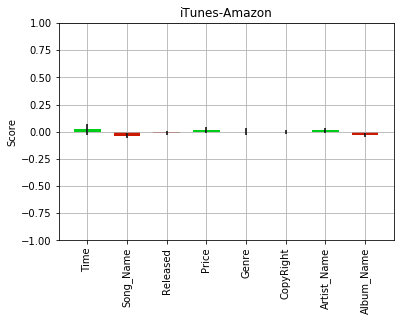

In [22]:
chart(tp_result, (1, 1, 1), (-1, 1), title = "iTunes-Amazon")

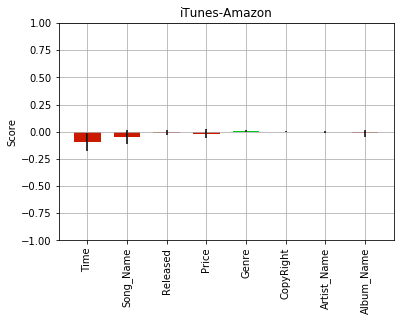

In [23]:
chart(tn_result, (1, 1, 1), (-1, 1), title = "iTunes-Amazon")